In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns; sns.set()
import scipy

In [2]:
# project files

from utils.variables import pack, unpack
from utils.display import table, tabulate
from utils.files import download_sheet, save, load
from utils.hash import digest

from fit_options import fit_options
from game_model import game
from rp_model import compute_rp, make_precomputed_columns
from initial_guess import make_initial_guess

In [3]:
# stuff for display

from IPython.lib.pretty import pretty, pprint

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 120)

In [4]:
data = pd.read_pickle(fit_options.data_file)
data.describe()
data.head()

,Level,RP,MS lvl,ModelRP,Difference,Freq1,FreqL,Inv,Berry1,BerryL,Ing1P,Helps per hour,Helps Neutral,NrgMult,IngrMult,SkillMult,Ingr%,SklContr,BerryD,IngD,Dupes,Amnt,Ing2P,Help skill bonus,RP Multiplier
count,7394.000000,7394.000000,7394.000000,7394.000000,7394.000000,7394.000000,7394.000000,7394.000000,7394.000000,7394.000000,7394.000000,7394.000000,7394.000000,7394.000000,7394.000000,7394.000000,7394.000000,7394.000000,7394.000000,7394.000000,7394.0,7394.000000,7394.000000,7394.000000,7394.000000
mean,11.159183,633.553827,1.531106,631.221396,-0.002029,3910.792534,3754.827046,12.358128,28.068434,38.351636,108.905058,1.035135,0.988096,0.994601,0.998999,1.007276,0.206731,34.558823,56.060319,148.205504,1.0,0.086827,3.585475,0.986585,1.030131
std,7.404413,413.293029,1.021303,413.930272,0.580695,973.915081,1037.172015,3.479251,2.616819,8.314996,16.191425,0.310743,0.058787,0.044944,0.117892,0.118634,0.045978,38.524205,28.135215,61.483427,0.0,0.557071,22.268253,0.039022,0.072489
min,1.000000,245.000000,1.000000,-1.000000,-21.000000,2200.000000,1489.118400,7.000000,24.000000,24.000000,90.000000,0.520000,0.890000,0.920000,0.800000,0.800000,0.000000,0.000000,25.000000,90.000000,1.0,0.000000,0.000000,0.790000,1.000000
25%,5.000000,361.000000,1.000000,360.000000,0.000000,3100.000000,2910.000000,10.000000,26.000000,33.000000,98.000000,0.810000,1.000000,1.000000,1.000000,1.000000,0.180000,13.160000,36.000000,101.000000,1.0,0.000000,0.000000,1.000000,1.000000
50%,10.000000,489.000000,1.000000,487.000000,0.000000,3800.000000,3731.600000,12.000000,28.000000,37.000000,103.000000,0.960000,1.000000,1.000000,1.000000,1.000000,0.200000,20.200000,46.000000,121.000000,1.0,0.000000,0.000000,1.000000,1.000000
75%,14.000000,746.000000,2.000000,743.000000,0.000000,4500.000000,4419.000000,14.000000,31.000000,42.000000,115.000000,1.230000,1.000000,1.000000,1.000000,1.000000,0.230000,47.682500,68.000000,202.000000,1.0,0.000000,0.000000,1.000000,1.000000
max,42.000000,3493.000000,6.000000,3495.000000,5.000000,6300.000000,6916.140000,24.000000,35.000000,83.000000,151.000000,2.410000,1.120000,1.080000,1.200000,1.200000,0.420000,414.090000,243.000000,511.000000,1.0,8.000000,342.000000,1.000000,1.440000


,Pokemon,Level,RP,Nature,MS lvl,Source,ModelRP,Difference,Nature2,ID,NatureP,NatureN,Freq1,FreqL,Type,Class,MSkill,Inv,Berry1,BerryL,Ing1,Ing1P,Helps per hour,Helps Neutral,NrgMult,IngrMult,SkillMult,Ingr%,SklContr,RPneutral,IDNeutral,BerryD,IngD,Dupes,DupeMatch,Sub Skill 1,Sub Skill 2,Ingredient 2,Amnt,Ing2P,Help skill bonus,RP Multiplier
0,Arbok,9.0,574.0,Naughty,1.0,Rate My Mon,574.0,0.0,Naughty,ArbokNaughty91,Speed of Help,Main Skill Chance,3700.0,3276.72,Poison,Berries,Charge Energy S,14.0,32.0,40,Bean Sausage,103.0,1.09,0.9,1.00,1.0,0.8,0.26,22.75,538.35,ArbokNeutral91,80.0,103.0,1,True,,,,0.0,0.0,1.0,1.0
1,Arbok,8.0,531.0,Hardy,1.0,Questions help guides,531.0,0.0,Neutral,ArbokNeutral81,-,-,3700.0,3648.20,Poison,Berries,Charge Energy S,14.0,32.0,39,Bean Sausage,103.0,0.98,1.0,1.00,1.0,1.0,0.26,22.75,531.00,ArbokNeutral81,78.0,103.0,1,True,,,,0.0,0.0,1.0,1.0
2,Arbok,8.0,538.0,Quiet,1.0,Questions help guides,538.0,0.0,Quiet,ArbokQuiet81,Ingredient Finding,Exp Gains,3700.0,3648.20,Poison,Berries,Charge Energy S,14.0,32.0,39,Bean Sausage,103.0,0.98,1.0,1.00,1.2,1.0,0.26,22.75,530.60,ArbokNeutral81,78.0,103.0,1,True,,,,0.0,0.0,1.0,1.0
3,Arbok,9.0,582.0,Relaxed,1.0,,582.0,0.0,Relaxed,ArbokRelaxed91,Energy Recovery,EXP Gains,3700.0,3640.80,Poison,Berries,Charge Energy S,14.0,32.0,40,Bean Sausage,103.0,0.98,1.0,1.08,1.0,1.0,0.26,22.75,538.89,ArbokNeutral91,80.0,103.0,1,True,,,,0.0,0.0,1.0,1.0
4,Arbok,9.0,489.0,Timid,1.0,,489.0,0.0,Timid,ArbokTimid91,EXP Gains,Speed of Help,3700.0,4004.88,Poison,Berries,Charge Energy S,14.0,32.0,40,Bean Sausage,103.0,0.89,1.1,1.00,1.0,1.0,0.26,22.75,538.45,ArbokNeutral91,80.0,103.0,1,True,,,,0.0,0.0,1.0,1.0


In [5]:
# Make an initial guess
# Pack the dictionary into a 1-D vector.
# Also store information on how to unpack that vector

x0, unpack_info = pack(make_initial_guess())
computed = make_precomputed_columns(data)

In [6]:
# We compute the RP model in rp_model.py
# Here we create closure to glue the pieces together.

def RP(x):
    return compute_rp(x, data, computed, unpack_info)

# for the error analysis page,
# we'll compute the residual with exact rounding.

def residual(x):
    return data["RP"] - np.round(RP(x))


In [7]:
filename = fit_options.result_file(digest(data, x0))
opt = load(filename)
sol = unpack(opt.x, unpack_info)

opt

    message: `ftol` termination condition is satisfied.
    success: True
     status: 2
          x: [ 2.563e-01  2.544e-01 ...  2.210e-01  2.211e-01]
       cost: 1160.2490719227876
       grad: [-2.782e-05 -5.842e-06 ...  0.000e+00  0.000e+00]
 optimality: 0.43414554256014526
       nfev: 19
       njev: 7

In [8]:
# What are the worst points?

df = data[["Pokemon","ID","Level","Class","Inv","MS lvl","NatureP","NatureN","Sub Skill 1","Sub Skill 2","RP"]].copy()

df["fit"] = np.round(RP(opt.x))
df["error"] = residual(opt.x)
df["error2"] = df["error"]**2

df = df.sort_values("error2", ascending = False)
df.head(100)

,Pokemon,ID,Level,Class,Inv,MS lvl,NatureP,NatureN,Sub Skill 1,Sub Skill 2,RP,fit,error,error2
3990,Glaceon,GlaceonNeutral276Skill Level Up MHelping Speed M,27.0,Skills,12.0,6.0,-,-,Skill Level Up M,Helping Speed M,2485.0,2470.0,15.0,225.0
533,Charizard,CharizardNeutral273Berry Finding SHelping Speed M,27.0,Ingredients,19.0,3.0,-,-,Berry Finding S,Helping Speed M,1528.0,1520.0,8.0,64.0
3159,Togekiss,TogekissGentle103Skill Trigger M,10.0,Skills,16.0,3.0,Main Skill Chance,Energy Recovery,Skill Trigger M,,1282.0,1274.0,8.0,64.0
530,Charizard,CharizardRash273Helping bonusHelping Speed M,27.0,Ingredients,19.0,3.0,Ingredient Finding,Main Skill Chance,Helping bonus,Helping Speed M,1440.0,1432.0,8.0,64.0
3134,Sylveon,SylveonRelaxed102Helping bonus,10.0,Skills,15.0,2.0,Energy Recovery,EXP Gains,Helping bonus,,1023.0,1016.0,7.0,49.0
3325,Typhlosion,TyphlosionCareful273Berry Finding SHelping Spe...,27.0,Berries,23.0,3.0,Main Skill Chance,Ingredient Finding,Berry Finding S,Helping Speed M,1761.0,1754.0,7.0,49.0
517,Charizard,CharizardNeutral273Inventory Up MHelping Speed M,27.0,Ingredients,19.0,3.0,-,-,Inventory Up M,Helping Speed M,1299.0,1292.0,7.0,49.0
4001,Flareon,FlareonGentle102Helping Speed S,10.0,Skills,14.0,2.0,Main Skill Chance,Energy Recovery,Helping Speed S,,849.0,843.0,6.0,36.0
3978,Leafeon,LeafeonBrave102Helping Speed S,10.0,Skills,13.0,2.0,Speed of Help,EXP Gains,Helping Speed S,,919.0,913.0,6.0,36.0
535,Charizard,CharizardMild276Skill Level Up MHelping Speed M,27.0,Ingredients,19.0,6.0,Ingredient Finding,Energy Recovery,Skill Level Up M,Helping Speed M,1514.0,1508.0,6.0,36.0


In [9]:
# What are the worst points, level 1-9, Main Skill 1 ?
level_1_9 = df[(df["Level"]<10) ]
level_1_9_error =  level_1_9[ level_1_9["error2"] > 0.5 ]

level_1_9.describe()
level_1_9_error.describe()
level_1_9_error.head(100)

,Level,Inv,MS lvl,RP,fit,error,error2
count,3386.000000,3386.000000,3386.000000,3386.000000,3386.000000,3386.000000,3386.000000
mean,5.185174,10.510041,1.038689,375.725635,375.731542,-0.005907,0.048435
std,2.289717,2.276990,0.213248,84.156010,84.155288,0.220032,0.214715
min,1.000000,7.000000,1.000000,245.000000,245.000000,-1.000000,0.000000
25%,3.000000,9.000000,1.000000,321.000000,321.000000,0.000000,0.000000
50%,5.000000,10.000000,1.000000,355.000000,355.000000,0.000000,0.000000
75%,7.000000,12.000000,1.000000,407.000000,407.000000,0.000000,0.000000
max,9.000000,21.000000,3.000000,1089.000000,1088.000000,1.000000,1.000000


,Level,Inv,MS lvl,RP,fit,error,error2
count,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.0
mean,4.963415,11.146341,1.176829,422.615854,422.737805,-0.121951,1.0
std,2.426566,2.647476,0.442192,147.596839,147.549258,0.995576,0.0
min,1.000000,8.000000,1.000000,262.000000,263.000000,-1.000000,1.0
25%,3.000000,9.750000,1.000000,332.750000,331.750000,-1.000000,1.0
50%,5.000000,10.000000,1.000000,373.000000,373.000000,-1.000000,1.0
75%,7.000000,12.000000,1.000000,452.500000,453.500000,1.000000,1.0
max,9.000000,21.000000,3.000000,1089.000000,1088.000000,1.000000,1.0


,Pokemon,ID,Level,Class,Inv,MS lvl,NatureP,NatureN,Sub Skill 1,Sub Skill 2,RP,fit,error,error2
1879,Magnemite,MagnemiteQuiet51,5.0,Skills,8.0,1.0,Ingredient Finding,Exp Gains,,,347.0,348.0,-1.0,1.0
2781,Spheal,SphealModest41,4.0,Berries,9.0,1.0,Ingredient Finding,Speed of Help,,,302.0,303.0,-1.0,1.0
761,Cyndaquil,CyndaquilAdamant51,5.0,Berries,14.0,1.0,Speed of Help,Ingredient Finding,,,447.0,446.0,1.0,1.0
1388,Graveler,GravelerQuiet91,9.0,Ingredients,12.0,1.0,Ingredient Finding,Exp Gains,,,512.0,513.0,-1.0,1.0
2402,Pikachu,PikachuSassy51,5.0,Berries,17.0,1.0,Main Skill Chance,EXP Gains,,,502.0,503.0,-1.0,1.0
1387,Graveler,GravelerNeutral91,9.0,Ingredients,12.0,1.0,-,-,,,470.0,471.0,-1.0,1.0
772,Cyndaquil,CyndaquilCareful51,5.0,Berries,14.0,1.0,Main Skill Chance,Ingredient Finding,,,409.0,408.0,1.0,1.0
2406,Pikachu,PikachuTimid61,6.0,Berries,17.0,1.0,EXP Gains,Speed of Help,,,457.0,458.0,-1.0,1.0
2416,Psyduck,PsyduckAdamant31,3.0,Skills,8.0,1.0,Speed of Help,Ingredient Finding,,,357.0,356.0,1.0,1.0
787,Cyndaquil,CyndaquilMild21,2.0,Berries,14.0,1.0,Ingredient Finding,Energy Recovery,,,362.0,361.0,1.0,1.0


intercept,0.000880965
intercept_stderr,0.0116309
pvalue,0.774683
rvalue,-0.00332954
slope,-0.00024862
stderr,0.000868495


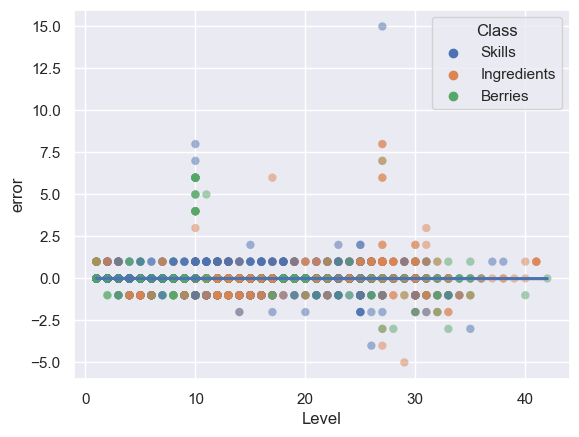

In [10]:
# Plot error vs level

err = df[["Level","error","Class"]]
palette = sns.color_palette(n_colors=3)

_ = sns.scatterplot(data=err, x="Level", y="error", hue="Class", alpha=0.5, linewidth=0, palette=palette)
_ = sns.regplot(data=err, x="Level", y="error", scatter=False)

# What is the slope?
linearfit = scipy.stats.linregress(x=err["Level"], y=err["error"])
table(linearfit)

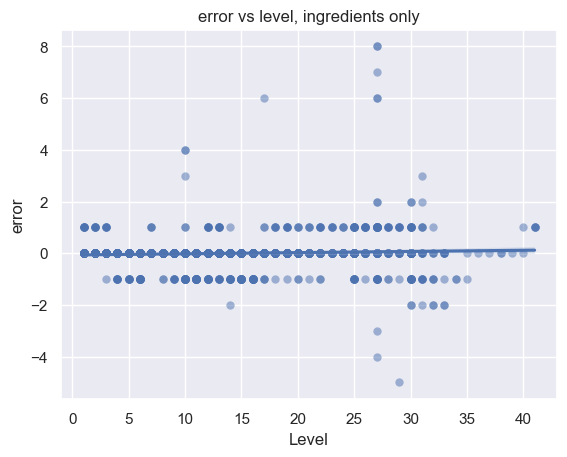

In [11]:
err2 = err[ err["Class"]=="Ingredients" ]
p = sns.scatterplot(data=err2, x="Level", y="error", alpha=0.5, linewidth=0, color=palette[0])
_ = sns.regplot(data=err2, x="Level", y="error", scatter=False)
_ = p.set(title='error vs level, ingredients only')


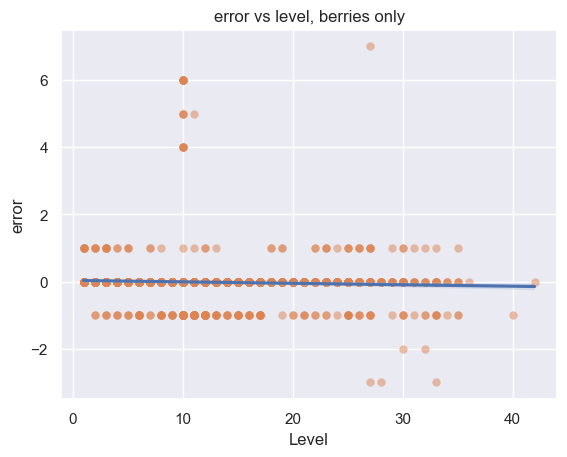

In [12]:
err2 = err[ err["Class"]=="Berries" ]
p = sns.scatterplot(data=err2, x="Level", y="error", alpha=0.5, linewidth=0, color=palette[1])
_ = sns.regplot(data=err2, x="Level", y="error", scatter=False)
_ = p.set(title='error vs level, berries only')

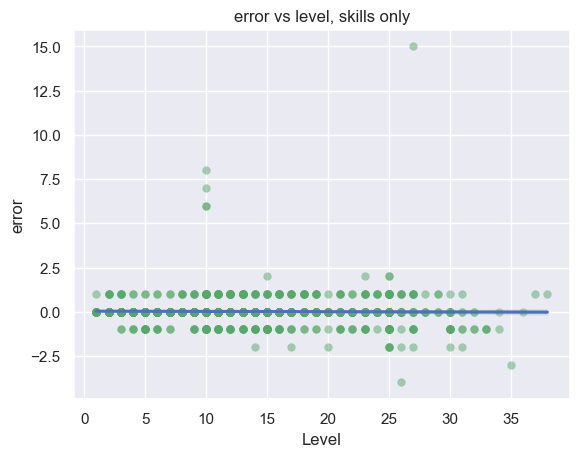

In [13]:
err2 = err[ err["Class"]=="Skills" ]

p = sns.scatterplot(data=err2, x="Level", y="error", alpha=0.5, linewidth=0, color=palette[2])
_ = sns.regplot(data=err2, x="Level", y="error", scatter=False)
_ = p.set(title='error vs level, skills only')


intercept,-0.0121982
intercept_stderr,0.00795695
pvalue,0.903001
rvalue,-0.00168689
slope,-0.000100127
stderr,0.000821537


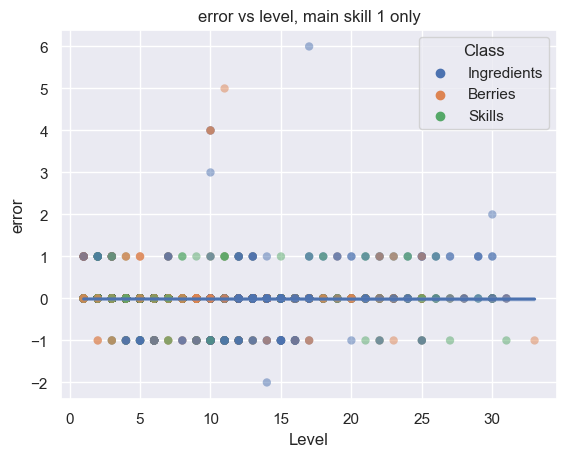

In [14]:
# Plot error vs level - focus on main skill 1

err = df[["Level","error","Class"]].loc[df["MS lvl"]==1]

p = sns.scatterplot(data=err, x="Level", y="error", hue="Class", alpha=0.5, linewidth=0)
_ = sns.regplot(data=err, x="Level", y="error", scatter=False)

_ = p.set(title='error vs level, main skill 1 only')

# What is the slope ?
linearfit = scipy.stats.linregress(x=err["Level"], y=err["error"])
table(linearfit)

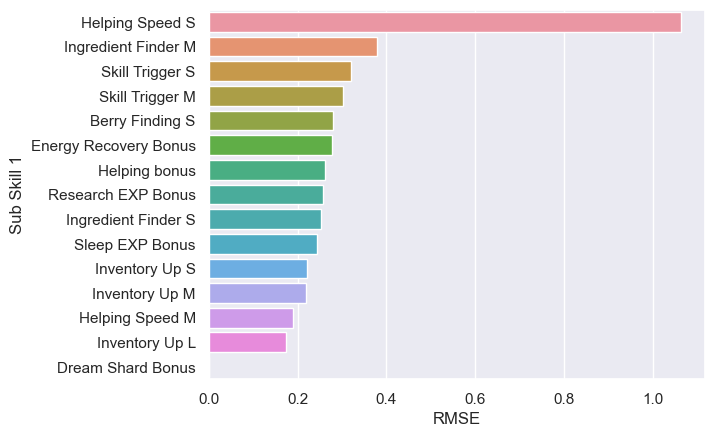

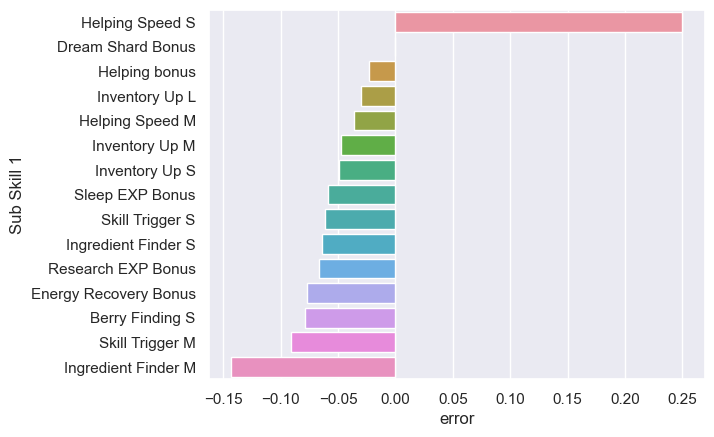

In [15]:
# Let's see what happens at level 10 and main skill 1

subskill_err = ( df[["Level", "Sub Skill 1", "error", "error2"]].loc[ (df["Level"]==10) & (df["MS lvl"]==1) ]
                .groupby("Sub Skill 1")
                .mean()
                .sort_values("error2", ascending = False)
                .reset_index() )

subskill_err["RMSE"] = np.sqrt(subskill_err["error2"])

_ = plt.figure()
_ = sns.barplot(data=subskill_err, y="Sub Skill 1", x="RMSE")

_ = plt.figure()
_ = sns.barplot(data=subskill_err.sort_values("error", ascending = False), y="Sub Skill 1", x="error")


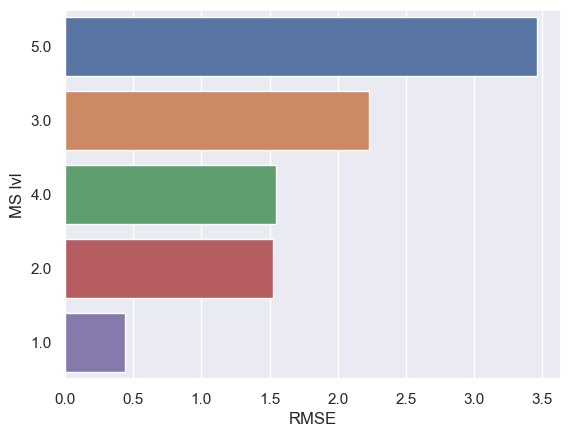

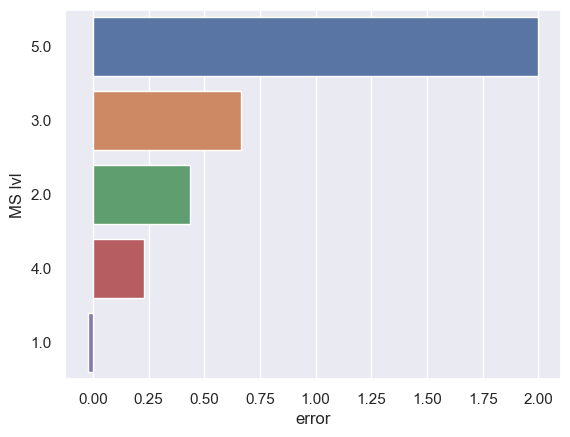

In [16]:
mslvl_err = ( df[["Level", "MS lvl", "error", "error2"]][df["Level"]==10]
                .groupby("MS lvl")
                .mean()
                .sort_values("error2", ascending = False)
                .reset_index() )

mslvl_err["RMSE"] = np.sqrt(mslvl_err["error2"])
mslvl_err["MS lvl"] = mslvl_err["MS lvl"].astype(str)

_ = plt.figure()
_ = sns.barplot(data=mslvl_err, y="MS lvl", x="RMSE")

_ = plt.figure()
_ = sns.barplot(data=mslvl_err.sort_values("error", ascending = False), y="MS lvl", x="error")


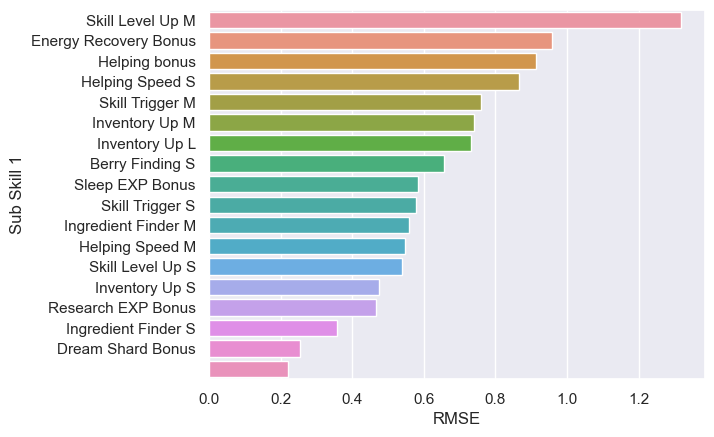

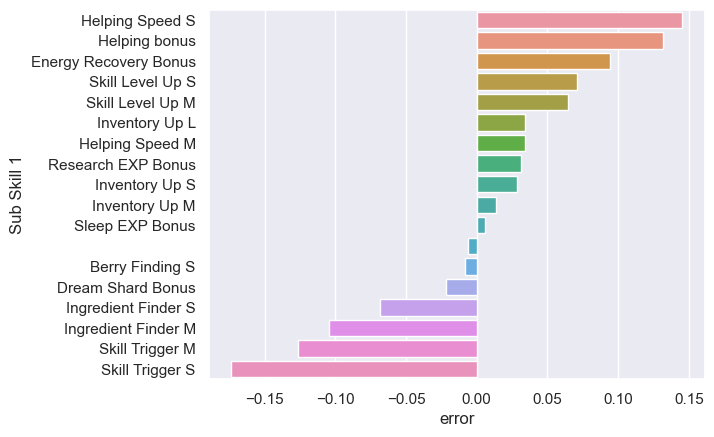

In [17]:
# Do we have more error in some skills ?

errorbyskill1 = (df[["Sub Skill 1","error","error2"]]
                .groupby("Sub Skill 1")
                .mean()
                .sort_values("error2", ascending = False)
                #.rename(columns={"error":"avg abs error"})
                .reset_index() )

errorbyskill1["RMSE"] = np.sqrt(errorbyskill1["error2"])
    
_ = plt.figure()
_ = sns.barplot(data=errorbyskill1, y="Sub Skill 1", x="RMSE")

_ = plt.figure()
_ = sns.barplot(data=errorbyskill1.sort_values("error", ascending = False), y="Sub Skill 1", x="error")

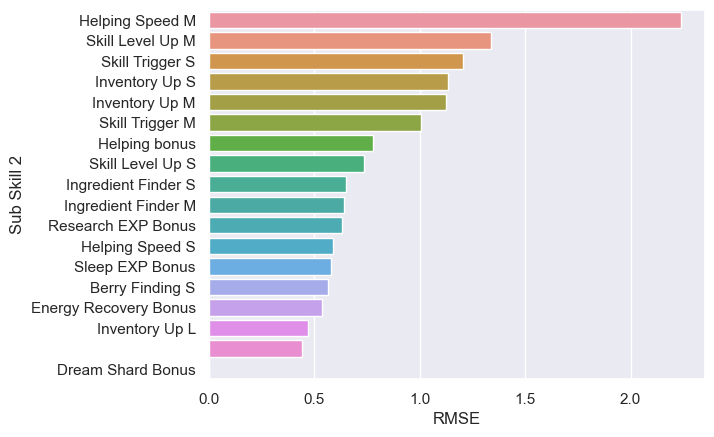

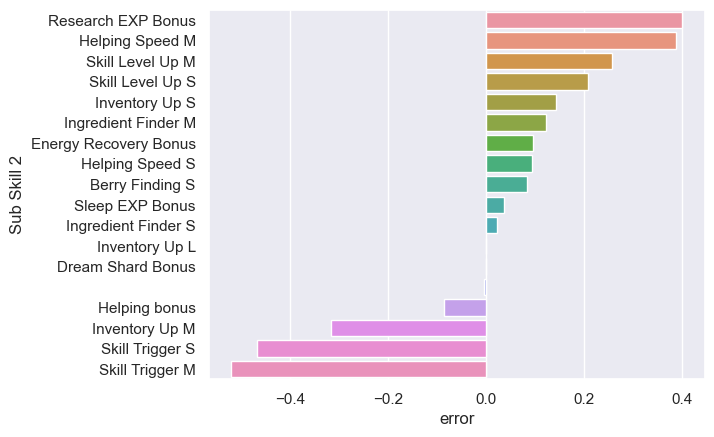

In [18]:
errorbyskill2 = (df[["Sub Skill 2","error","error2"]]
                .groupby("Sub Skill 2")
                .mean()
                .sort_values("error2", ascending = False)
                #.rename(columns={"error":"avg abs error"})
                .reset_index() )

errorbyskill2["RMSE"] = np.sqrt(errorbyskill2["error2"])
    
_ = plt.figure()
_ = sns.barplot(data=errorbyskill2, y="Sub Skill 2", x="RMSE")

_ = plt.figure()
_ = sns.barplot(data=errorbyskill2.sort_values("error", ascending = False), y="Sub Skill 2", x="error")